<a href="https://colab.research.google.com/github/gimenopea/CSCI6364/blob/main/MNIST_DataSet_KNN_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**KNN Implementation of the MNIST dataset w/o ML Libraries**

CSCI6364 | Fall 2022
Project 1 | part B

pgimeno@gwu.edu


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import pickle

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---


I. **Exploratory Data Analysis**


---




In [83]:
df = pd.read_csv('/content/drive/MyDrive/DATA_STORE/mnist-train.csv')

In [84]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


- The image contains 783 features and is a a collection of 28x28 images
- Our target labels are images from 0 to 9

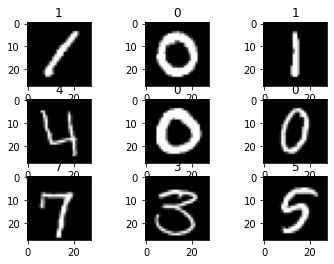

In [85]:
def show_image(df):

    label = df.label
    pixels = df.drop(labels = ["label"],axis = 1)

    pixels = np.array(pixels)
    label = np.array(label)
    

    pixels = pixels.reshape(pixels.shape[0], 28, 28)

    for i in range(0, 9):
        plt.subplot(330 + (i+1))
        plt.imshow(pixels[i], cmap=plt.get_cmap('gray'))
        plt.title(label[i]);

show_image(df)

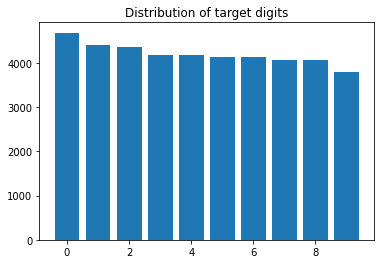

In [86]:
#plotting class distribution of our labels
plt.bar(x = sorted(df.label.unique()), height=[i for i in df.label.value_counts()])
plt.title('Distribution of target digits');

- The distribution of the labels in this dataset appears to be balanced across all classes

II. Sample reduction 

In [87]:
df_sample = df.groupby('label', group_keys=False).apply(lambda x: x.sample(1000)) #samples 1000 of each targets
df_sample.label.value_counts()

0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: label, dtype: int64

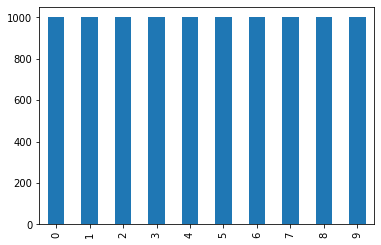

In [88]:
#plot distribution of labels in df_sample
df_sample.label.value_counts().plot(kind='bar')




---


II. **Train Test Split: Splitting data into training, testing and validation sets**


---

Training = 80% of data

Validation = 10% of data

Testing = 10% of data



In [89]:
# add a dataframe column which labels our row samples as either train, test or validation
def train_test_split(df, test_size=0.2):
    train = df_sample.sample(frac=1-test_size, random_state=666)
    validation = df_sample.drop(train.index)
    test = validation.sample(frac=.5, random_state=666)
    validation = validation.drop(test.index)

    #shuffle dataframes
    train = train.sample(frac=1).reset_index(drop=True)
    validation = validation.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)

    #split into X and y
    X_train = train.drop('label', axis=1)
    y_train = train.label
    X_validation = validation.drop('label', axis=1)
    y_validation = validation.label
    X_test = test.drop('label', axis=1)
    y_test = test.label

    #convert to numpy arrays
    X_train = X_train.values
    y_train = y_train.values
    X_validation = X_validation.values
    y_validation = y_validation.values
    X_test = X_test.values
    y_test = y_test.values

    #print shapes
    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_validation shape:', X_validation.shape)
    print('y_validation shape:', y_validation.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    
    return X_train, y_train, X_validation, y_validation, X_test, y_test



---
III. **Normalizing our feature vectors:**

---





As a pre-processing task, i am scaling down the features so that our min and max values falls in the range between 0 and 1. The main function transforms our row vector using the equation below 

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/358923abc154221bb5022fc329061f6fc4dcc69f'>


[Reference](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))

In [90]:
#function to normalize input dataFrame

def normalize(X_train, X_validation, X_test):
    #get the max and min values of X_train
    max_value = X_train.max()
    min_value = X_train.min()

    #normalize X_train, X_validation and X_test
    X_train = (X_train - min_value)/(max_value - min_value)

    X_validation = (X_validation - min_value)/(max_value - min_value)

    X_test = (X_test - min_value)/(max_value - min_value)

    return X_train, X_validation, X_test

- for the normalization process, the training max and min's are used for both the validation and the test sets



---


IV. **Generating the distance function**


---



For these classification tasks, i am implementing euclidean distances and the Manhattan distance to calculate distances between two sample points

**Euclidean Distance** function will be derived from:

<img src='https://www.gstatic.com/education/formulas2/472522532/en/euclidean_distance.svg'>

**Manhattan Distance** function will be derived from

<img src='https://miro.medium.com/max/640/1*KDgfdK6SooXtaUvlnXdpaA.png'>

In [91]:
def calc_euclidean_dist(x1, x2):
  return np.sqrt(np.sum((x1 - x2)**2))

def calc_manhattan_dist(x1, x2):
    return np.sum(np.abs(x1 - x2))

def minkowski_distance(x1, x2, p):
  return np.sum(np.abs(x1-x2)**p)**(1/p)
 



---


V. **Generating a prediction on test data**


---



In [92]:
#create a predict function for each test row sample

def knn_predict(X_train, y_train, X_validation, k = 1, distance_func = calc_euclidean_dist):
  ''' input numpy array X_train, y_train, X_validation
  outputs: numpy array of predictions '''
  

  predictions = []

  for i,v_validation in enumerate(X_validation):
      distance = []
      for j,v_train in enumerate(X_train):
      
          dist = distance_func(v_validation, v_train)
          
          distance.append(dist)
    
      numpied_distance = np.array(distance)

      #get k smallest distances using O(n) method np.argpartition. this variable is an array of indices of the k smallest distances.
      smallest = np.argpartition(numpied_distance, k)[:k]

      #get the labels in the training y targets
      vals = y_train[smallest]

      #if tie, use first in training set
      majority_label = np.bincount(vals).argmax()

      #prediction at index i
      predictions.append(majority_label)

  return np.array(predictions)

 

In [93]:
#function to produce a 10x10 confusion matrix
def confusion_matrix(y_actual, y_predict):
  '''inputs two numpy array of size n (n,1) and returns a 10x10 numpy array'''
  
  confusion_matrix = np.zeros((10,10), dtype=int)
  for i in range(len(y_actual)):
      confusion_matrix[y_actual[i], y_predict[i]] += 1
  return confusion_matrix

def matrix_accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

def accuracy_per_digit(confusion_matrix):
    accuracy_per_digit = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
    return accuracy_per_digit

def f1_score(confusion_matrix):
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
    f1 = 2 * (precision * recall) / (precision + recall)
    return recall, precision, f1
    


In [94]:
#generating a run function

run_df = df.copy()
df_sample = run_df.groupby('label', group_keys=False).apply(lambda x: x.sample(1000))
print(f'\ntrain_test_split_summary on sample size {df_sample.shape}\n')
X_train, y_train, X_validation, y_validation, X_test, y_test = train_test_split(df_sample,test_size=0.2)
X_train, X_validation, X_test = normalize(X_train, X_validation, X_test)


def run(X_train, y_train, X_validation, y_validation, k=1, distance_function = calc_euclidean_dist):
  
  print(f'{"-"*30}')
  print(f'\nI. Begin run at k: {k} using distance function: < {distance_function.__name__}>')
  #print(f'{"-"*30}')
  begin = time.time()
  preds = knn_predict(X_train, y_train, X_validation, k, distance_func=distance_function)
  print(f'\nII. Run KNN training wall time {round(time.time() - begin,2)} seconds\n')


  print(f'\nIII. Confusion Matrix\n')
  conf_matrix = confusion_matrix(y_validation,preds)
  print(conf_matrix)
  
  print(f'\nIV. Matrix Accuracy: {matrix_accuracy(conf_matrix)}\n')
  digit_accuracy = accuracy_per_digit(conf_matrix)
  print(f'\nV. Digit Accuracy: {digit_accuracy}\n')
  print(f'{"-"*30}\n')

  recall, precision, f1 = f1_score(conf_matrix)
  print(f'VI. Digit Precision: {precision}\n\nDigit Recall: {recall}\n\nDigit F1 Score {f1}')
  return preds, conf_matrix, y_validation


train_test_split_summary on sample size (10000, 785)

X_train shape: (8000, 784)
y_train shape: (8000,)
X_validation shape: (1000, 784)
y_validation shape: (1000,)
X_test shape: (1000, 784)
y_test shape: (1000,)


In [95]:
preds, cm, actual = run(X_train, y_train, X_validation, y_validation,k=1,distance_function= calc_euclidean_dist)

------------------------------

I. Begin run at k: 1 using distance function: < calc_euclidean_dist>

II. Run KNN training wall time 98.97 seconds


III. Confusion Matrix

[[100   0   0   0   0   0   2   0   0   0]
 [  0 101   0   0   0   0   0   0   0   0]
 [  1   2  88   0   1   0   0   2   1   0]
 [  0   0   0  88   0   1   0   2   3   1]
 [  0   1   0   0 102   0   1   0   0   4]
 [  0   0   0   2   0  85   2   1   1   1]
 [  2   1   0   0   0   1  86   0   0   0]
 [  0   0   1   0   0   0   0  92   0   2]
 [  0   1   0   1   0   3   0   0  94   1]
 [  0   0   0   3   4   0   0  10   0 105]]

IV. Matrix Accuracy: 0.941


V. Digit Accuracy: [0.98039216 1.         0.92631579 0.92631579 0.94444444 0.92391304
 0.95555556 0.96842105 0.94       0.86065574]

------------------------------

VI. Digit Precision: [0.97087379 0.95283019 0.98876404 0.93617021 0.95327103 0.94444444
 0.94505495 0.85981308 0.94949495 0.92105263]

Digit Recall: [0.98039216 1.         0.92631579 0.92631579 0.944444

In [96]:
#sanity check
preds[:10]

array([7, 3, 9, 5, 8, 4, 5, 7, 1, 0])

In [97]:
actual[:10]

array([7, 3, 9, 5, 8, 4, 5, 7, 1, 0])

---

Find a combination of distance function and K that provides the best accuracy and low runtimes

---

In [98]:
# generate a run sequence
run_df = df.copy()
df_sample = run_df.groupby('label', group_keys=False).apply(lambda x: x.sample(1000))  
X_train, y_train, X_validation, y_validation, X_test, y_test = train_test_split(df_sample,test_size=0.2)


def grid_find_best(X_train, y_train, X_validation, y_validation, X_test, y_test, max_k=1, number_to_focus=1):
  distance_functions = [calc_euclidean_dist, calc_manhattan_dist]  
  performance_log = []
  
  def run():
    begin = time.time()
    preds = knn_predict(X_train, y_train, X_validation, k=i, distance_func=j)
    walltime = round(time.time() - begin,2)
    conf_matrix = confusion_matrix(y_validation,preds)
    digit_accuracy = accuracy_per_digit(conf_matrix)
    recall, precision, f1 = f1_score(conf_matrix)
    performance_log.append((i,j.__name__,matrix_accuracy(conf_matrix),digit_accuracy[number_to_focus-1],walltime,recall[number_to_focus-1], precision[number_to_focus-1], f1[number_to_focus-1]))

  for i in range(1,max_k):
   
    for j in distance_functions:
      if i < 3:
        print(f'{"-"*30}')
        print(f'I. Begin run at k: {i} using distance function: < {j.__name__}>')  
  
        begin = time.time()
        preds = knn_predict(X_train, y_train, X_validation, k=i, distance_func=j)
        walltime = round(time.time() - begin,2)
        print(f'II. Run KNN training wall time {walltime} seconds')
        conf_matrix = confusion_matrix(y_validation,preds)
    
        print(f'III. Matrix Accuracy: {matrix_accuracy(conf_matrix)}')
      
        digit_accuracy = accuracy_per_digit(conf_matrix)
        recall, precision, f1 = f1_score(conf_matrix)
        performance_log.append((i,
                                j.__name__,
                                matrix_accuracy(conf_matrix),
                                digit_accuracy[number_to_focus-1],
                                walltime,
                                recall[number_to_focus-1],precision[number_to_focus-1],f1[number_to_focus-1]))
        print(f'IV. Digit Accuracy of number {number_to_focus}: {digit_accuracy[number_to_focus-1]}')
      elif i == 3:
        print('...cont....')
      else:
       run()

  return performance_log

X_train shape: (8000, 784)
y_train shape: (8000,)
X_validation shape: (1000, 784)
y_validation shape: (1000,)
X_test shape: (1000, 784)
y_test shape: (1000,)


In [99]:
grid_performance = grid_find_best(X_train, y_train, X_validation, y_validation, X_test, y_test, max_k=20, number_to_focus=3)

------------------------------
I. Begin run at k: 1 using distance function: < calc_euclidean_dist>
II. Run KNN training wall time 109.72 seconds
III. Matrix Accuracy: 0.942
IV. Digit Accuracy of number 3: 0.9368421052631579
------------------------------
I. Begin run at k: 1 using distance function: < calc_manhattan_dist>
II. Run KNN training wall time 84.3 seconds
III. Matrix Accuracy: 0.934
IV. Digit Accuracy of number 3: 0.9052631578947369
------------------------------
I. Begin run at k: 2 using distance function: < calc_euclidean_dist>
II. Run KNN training wall time 104.69 seconds
III. Matrix Accuracy: 0.93
IV. Digit Accuracy of number 3: 0.9473684210526315
------------------------------
I. Begin run at k: 2 using distance function: < calc_manhattan_dist>
II. Run KNN training wall time 83.82 seconds
III. Matrix Accuracy: 0.915
IV. Digit Accuracy of number 3: 0.8947368421052632
...cont....
...cont....


In [110]:
perf = pd.DataFrame(grid_performance, columns=['k', 'distance', 'accuracy', 'digit_accuracy','walltime_secs', 'recall','precision','f1'])
perf

,k,distance,accuracy,digit_accuracy,walltime_secs,recall,precision,f1
0,1,calc_euclidean_dist,0.942,0.936842,109.72,0.936842,0.988889,0.962162
1,1,calc_manhattan_dist,0.934,0.905263,84.30,0.905263,0.988506,0.945055
2,2,calc_euclidean_dist,0.930,0.947368,104.69,0.947368,0.967742,0.957447
3,2,calc_manhattan_dist,0.915,0.894737,83.82,0.894737,0.955056,0.923913
4,4,calc_euclidean_dist,0.934,0.905263,111.77,0.905263,0.955556,0.929730
5,4,calc_manhattan_dist,0.923,0.884211,83.71,0.884211,0.954545,0.918033
6,5,calc_euclidean_dist,0.940,0.894737,109.73,0.894737,0.965909,0.928962
7,5,calc_manhattan_dist,0.930,0.884211,81.12,0.884211,0.988235,0.933333
8,6,calc_euclidean_dist,0.936,0.894737,103.43,0.894737,0.965909,0.928962
9,6,calc_manhattan_dist,0.928,0.894737,81.15,0.894737,0.977011,0.934066


In [111]:
import pickle

save_path = '/content/drive/MyDrive/DATA_STORE/mnist_perf_params_1k_samples.pkl'
pickle.dump(perf,open(save_path, 'wb'))


In [112]:
performance_reload = pickle.load(open(save_path, 'rb'))
perf = performance_reload

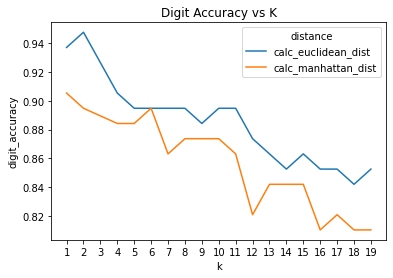

In [113]:
sns.lineplot(x='k', y='digit_accuracy', data=perf, hue='distance')
plt.xticks(np.arange(1, 20, 1.0))
plt.title('Digit Accuracy vs K');

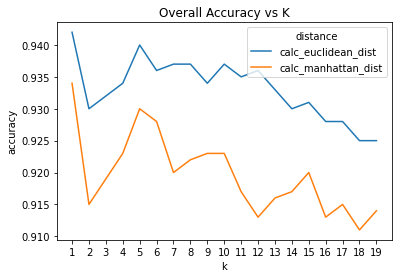

In [114]:
sns.lineplot(x='k', y='accuracy', data=perf, hue='distance')
plt.xticks(np.arange(1, 20, 1.0))
plt.title('Overall Accuracy vs K');


--- 

**Final Model Evaluation**

---

- based on validation data, the best parameters to pick for knn of sample size 10k evenly distributed images is K = 1 with a euclidean distance mode of calculating distances.
- This yields the highest accuracy for our validation set but has a higher runtime compared to using to the manhattan distance
- at K=3 using Euclidean distance, classifying the number **'3'** appears to yield the highest accurate prediction 


**running the model against the testing holdout set**

In [115]:
preds, cm, actual = run(X_train, y_train, X_test, y_test,k=1,distance_function= calc_euclidean_dist)

------------------------------

I. Begin run at k: 1 using distance function: < calc_euclidean_dist>

II. Run KNN training wall time 102.88 seconds


III. Confusion Matrix

[[ 88   0   0   0   0   1   0   0   0   0]
 [  0  97   0   0   0   0   0   1   0   1]
 [  0   1  90   1   0   0   0   2   1   0]
 [  0   0   0  86   0   1   0   1   5   1]
 [  0   1   0   0  94   0   1   2   0   5]
 [  0   0   0   3   1 101   1   0   1   1]
 [  1   0   0   0   0   2  92   0   1   0]
 [  0   1   0   0   0   0   0  92   0   2]
 [  2   4   1   3   0   0   0   0  95   3]
 [  1   0   0   0   5   0   0   7   0 100]]

IV. Matrix Accuracy: 0.935


V. Digit Accuracy: [0.98876404 0.97979798 0.94736842 0.91489362 0.91262136 0.93518519
 0.95833333 0.96842105 0.87962963 0.88495575]

------------------------------

VI. Digit Precision: [0.95652174 0.93269231 0.98901099 0.92473118 0.94       0.96190476
 0.9787234  0.87619048 0.9223301  0.88495575]

Digit Recall: [0.98876404 0.97979798 0.94736842 0.91489362 0.91262

In [117]:
#validation decision to use k = 1 with it's digit accuracy
perf.loc[:3]

,k,distance,accuracy,digit_accuracy,walltime_secs,recall,precision,f1
0,1,calc_euclidean_dist,0.942,0.936842,109.72,0.936842,0.988889,0.962162
1,1,calc_manhattan_dist,0.934,0.905263,84.30,0.905263,0.988506,0.945055
2,2,calc_euclidean_dist,0.930,0.947368,104.69,0.947368,0.967742,0.957447
3,2,calc_manhattan_dist,0.915,0.894737,83.82,0.894737,0.955056,0.923913



**Model Runtime**

- Implementation of this KNN follows a naive approach where in this experiment, the number of training samples n with m dimensions would yield an O(n x m) time complexity
- Manhattan distance calculations perform quicker in general as seen in the grid search experiments

In [122]:
#average_runtime of euclidean KNN's (s)
perf.walltime_secs.mean()

93.27666666666669